In [6]:
import torch
import numpy as np
import anacal
import matplotlib.pyplot as plt

Load in images, PSFs, and catalogs:

In [7]:
# path to one batch of generated images and psf parameters
image = torch.load('/data/scratch/descwl/batch_1_images.pt').numpy()
psf = torch.load('/data/scratch/descwl/batch_1_psf_params.pt')
catalog = torch.load('/data/scratch/descwl/batch_1_catalog.pt')

Extract true shear1 and shear2:

In [8]:
true_shear1 = catalog['shear_1'].squeeze()[:,0]
true_shear2 = catalog['shear_2'].squeeze()[:,0]

Compute AnaCal estimates of shear1 and shear2:

In [9]:
fpfs_config = anacal.fpfs.FpfsConfig(
    sigma_arcsec=0.52
)

mag_zero = 30.0
pixel_scale = 0.2
noise_variance = 0.23**2.0
noise_array = None
detection = None

band = 0  # r-band

est_shear1 = torch.zeros(len(image))
est_shear2 = torch.zeros(len(image))

for i in range(len(image)):
    gal_array = image[i,band]
    psf_array = psf[i]['psf_image']

    out = anacal.fpfs.process_image(
        fpfs_config=fpfs_config,
        mag_zero=mag_zero,
        gal_array=gal_array,
        psf_array=psf_array,
        pixel_scale=pixel_scale,
        noise_variance=noise_variance,
        noise_array=noise_array,
        detection=detection,
    )

    e1 = out["fpfs_w"] * out["fpfs_e1"]
    e1g1 = out["fpfs_dw_dg1"] * out["fpfs_e1"] + out["fpfs_w"] * out["fpfs_de1_dg1"]

    est_shear1[i] = np.sum(e1) / np.sum(e1g1)

    e2 = out["fpfs_w"] * out["fpfs_e2"]
    e2g2 = out["fpfs_dw_dg2"] * out["fpfs_e2"] + out["fpfs_w"] * out["fpfs_de2_dg2"]
    
    est_shear2[i] = np.sum(e2) / np.sum(e2g2)

Plot true vs. estimated shear1 and shear2:

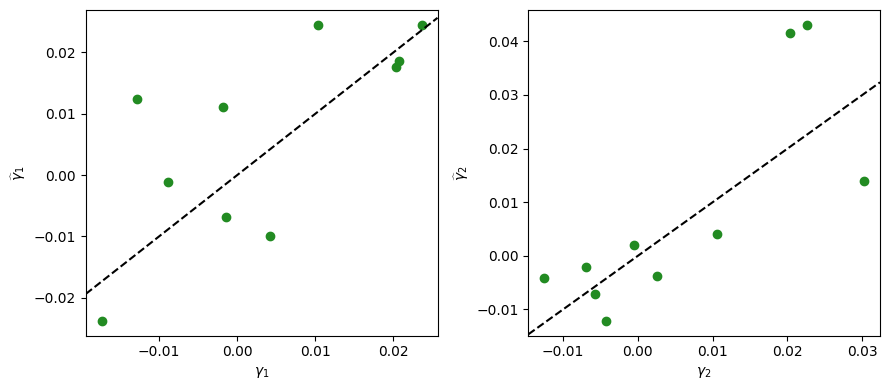

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (9, 4))

_ = ax[0].scatter(true_shear1, est_shear1, color = 'forestgreen')
_ = ax[0].axline((0,0), slope = 1, linestyle = 'dashed', color = 'black')
_ = ax[0].set_xlabel("$\gamma_1$")
_ = ax[0].set_ylabel("$\widehat{\gamma}_1$")

_ = ax[1].scatter(true_shear2, est_shear2, color = 'forestgreen')
_ = ax[1].axline((0,0), slope = 1, linestyle = 'dashed', color = 'black')
_ = ax[1].set_xlabel("$\gamma_2$")
_ = ax[1].set_ylabel("$\widehat{\gamma}_2$")

_ = fig.tight_layout()